# **Task 1: Build two recommender systems:**
###**1. The first one is to recommend the top 5 movies based on a given movie title.**
###**2. The second model will estimate the rating of a movie based on the user behaviour.**


# **What is a Recommendation System?**
Simply put a Recommendation System is a filtration program whose prime goal is to predict the “rating” or “preference” of a user towards a domain-specific item or item. 

#**What are the different filtration strategies?**
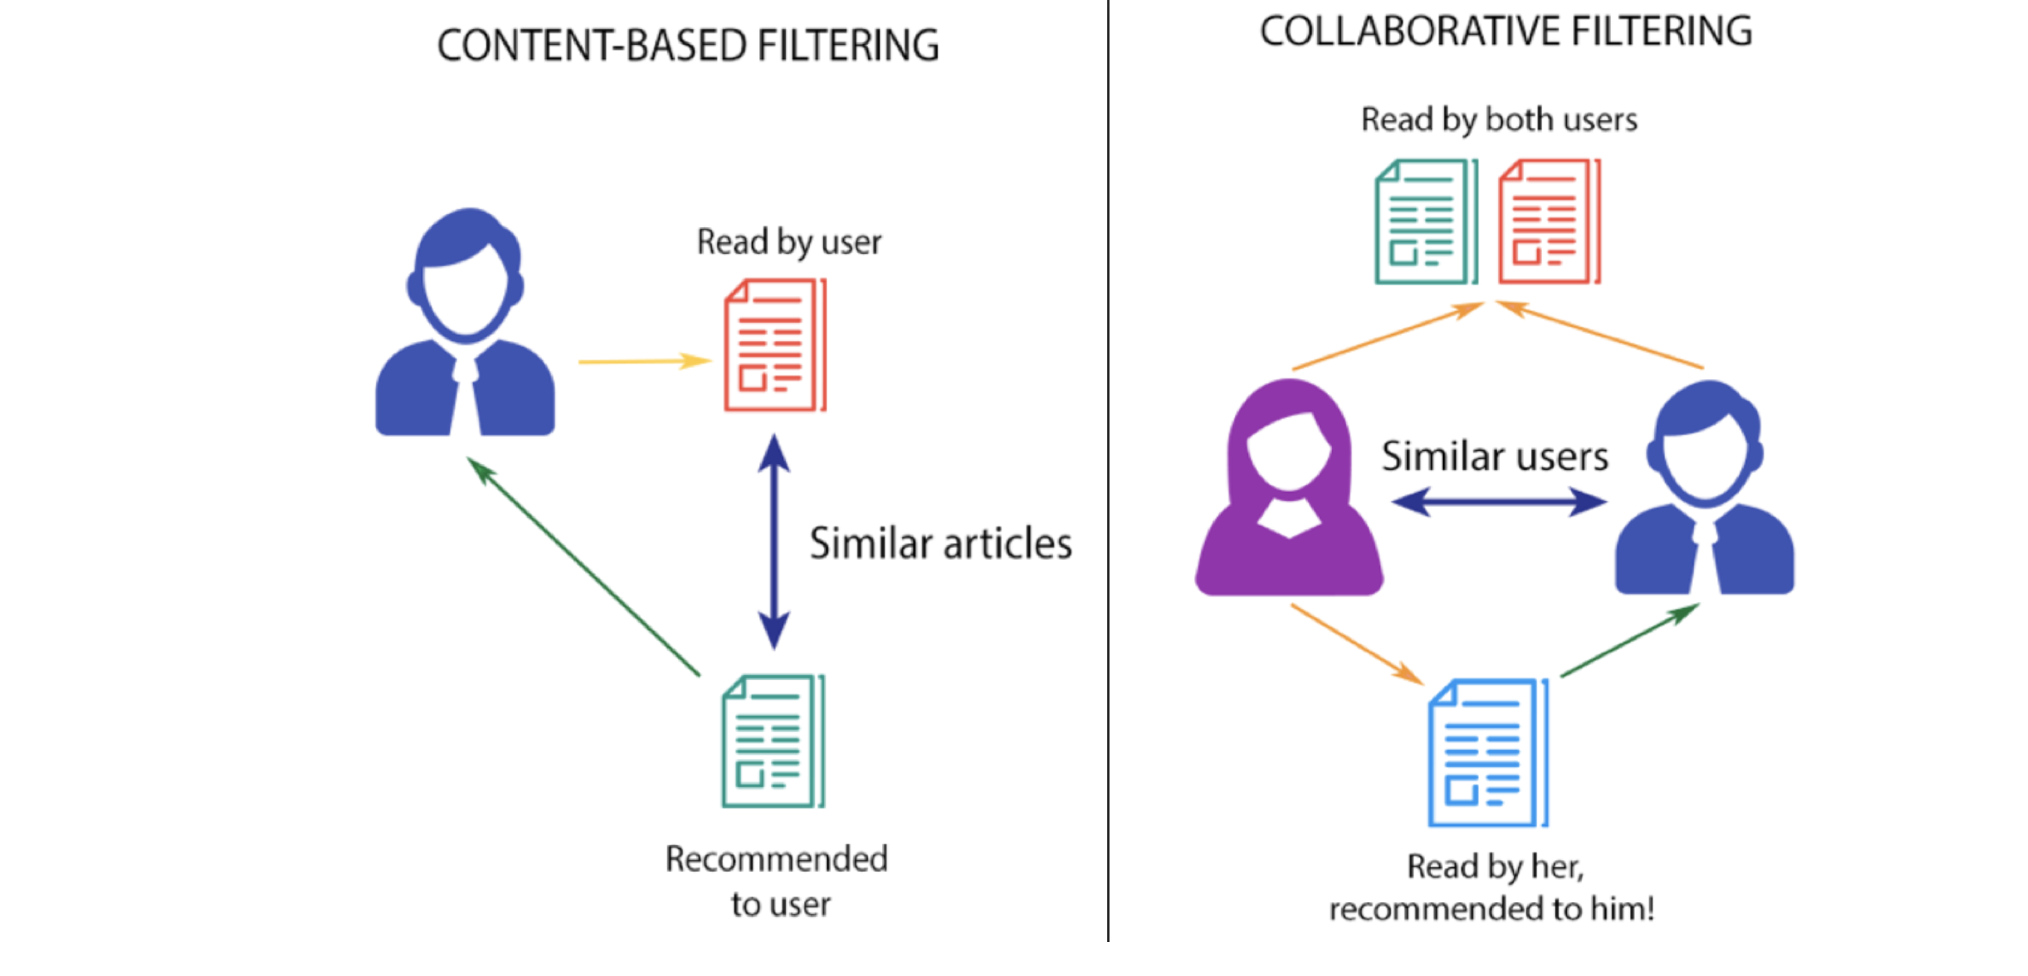



###**User-based Collaborative filtering**

The basic idea here is to find users that have similar past preference patterns as the user ‘A’ has had and then recommending him or her items liked by those similar users which ‘A’ has not encountered yet. 

###**Item-based Collaborative Filtering**
The concept in this case is to find similar movies instead of similar users and then recommending similar movies to that ‘A’ has had in his/her past preferences. 
 
##**Let’s start coding up our own Movie recommendation system**
In this implementation recommend the top 5 movies based on a given movie title. I will be using an **item-based collaborative filtering** algorithm for our purpose. The dataset used in this demonstration is the Movie Lens Small Latest Dataset.

Getting the data up and running
##**1.1 Import libraries**

In [ ]:
pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors as knn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict #data colector
import surprise
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import NMF

np.random.seed(42) # replicating results

##**1.2 Load the data**

In [ ]:
movies = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/movies.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/ratings.csv")

##**Let’s have a look at the movies dataset :**

In [ ]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


###Movie dataset has:

###**movieId** – once the recommendation is done, we get a list of all similar movieId and get the title for each movie from this dataset.
###**genres** – which is not required for this filtering approach.


In [ ]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


###Ratings dataset has:

**userId** – unique for each user.

**movieId** – using this feature when take the title of the movie from the movies dataset.

**rating** – Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies.

###To make things easier to understand and work with, we are going to make a new dataframe where each column would represent each unique userId and each row represents each unique movieId.

In [ ]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.fillna(0,inplace=True) #replace the NAN values with 0
final_dataset.head(3)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


### Now, it’s much easier to interpret that userId 1 has rated movieId 1& 3 4.0 but has not rated movieId 2,4,5 at all (therefore they are represented as 0.0 ) and therefore their rating data is missing.
##**1.3 Removing Noise from the data**
We wouldn’t take into account:
>movies that were rated by a small number of users because it’s not credible enough. 

>Users who have rated only a handful of movies should also not be taken into account.


**So let's add some filters for the final dataset.**
>To qualify a movie, a minimum of 10 users should have voted a movie.

>To qualify a user, a minimum of 50 movies should have voted by the user.


In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count') #Aggregating the number of users who voted-->movieID,number of users who voted
no_movies_voted = ratings.groupby('userId')['rating'].agg('count') #and the number of movies that were voted-->userID,number of movies that were voted

###**Let’s visualize:**
> ### **the number of users who voted with our threshold of 10.**
> ### **the number of votes by each user with our threshold of 50.**

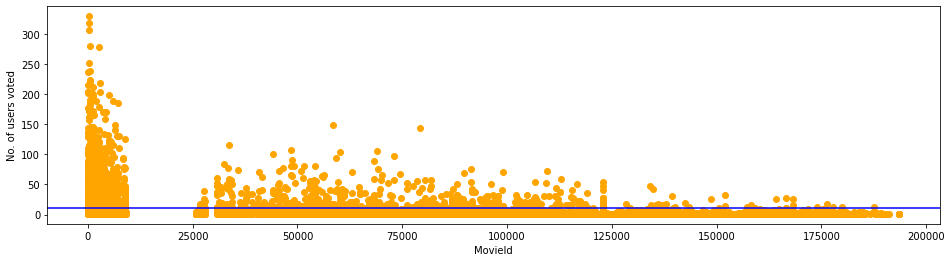

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='orange')
plt.axhline(y=10,color='blue')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

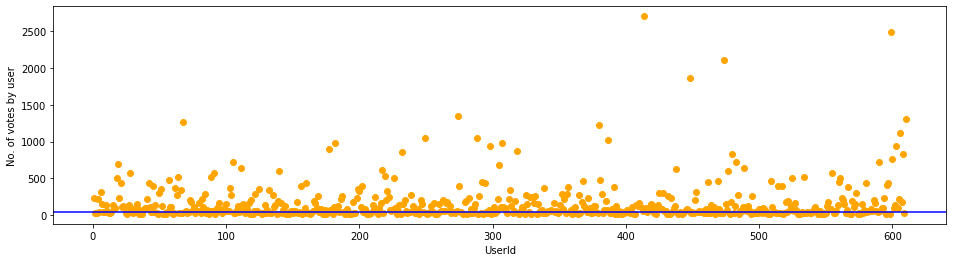

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='orange')
plt.axhline(y=50,color='blue')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

###**Now let's make the necessary modifications as per the threshold set.**

In [ ]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 2].index,:] #final dataset-->where each column represent userId
                                                                             #and each row represents movieId.
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 5].index]
final_dataset.shape

(4980, 610)

##**1.4. Removing sparsity**
Our final_dataset has dimensions of 2121 * 378 where most of the values are sparse. 
To reduce the sparsity we use the csr_matrix function from the scipy library.

 I’ll give an example of how it works :


In [ ]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


##**1.5 Applying the csr_matrix method to the dataset :**


In [ ]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

# **1.6 Making the movie recommendation system model**
We will be using the KNN algorithm to compute similarity with  metric.
##**Making the recommendation function**
First check if the movie name input is in the database and, **If** it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 5 movies with their distances from the input movie.


In [ ]:
knn = knn(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1) #n_neighbors=5, n_jobs=1 or -1

knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 5
    movie_list = movies[movies['title'].str.contains(movie_name)] #check if the movie name input is in the database
    #print( movie_list['title'])
    if len(movie_list):       
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1) 
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

#**Finally, Let’s Recommend some movies!**

In [ ]:
get_movie_recommendation('Iron Man')

[(6726, 0.0), (6693, 0.32946219051576764), (6755, 0.3322251199632066), (7675, 0.3413244923996469), (7307, 0.35801447096159067), (7195, 0.3757322316601438)]
[(7195, 0.3757322316601438), (7307, 0.35801447096159067), (7675, 0.3413244923996469), (6755, 0.3322251199632066), (6693, 0.32946219051576764)]


,Title,Distance
1,Avatar (2009),0.375732
2,Iron Man 2 (2010),0.358014
3,"Avengers, The (2012)",0.341324
4,WALL·E (2008),0.332225
5,"Dark Knight, The (2008)",0.329462


In [ ]:
get_movie_recommendation('Memento')

,Title,Distance
1,"Lord of the Rings: The Two Towers, The (2002)",0.348358
2,Eternal Sunshine of the Spotless Mind (2004),0.346196
3,"Matrix, The (1999)",0.326215
4,"Lord of the Rings: The Fellowship of the Ring,...",0.316777
5,Fight Club (1999),0.272380


#**2. The second model will estimate the rating of a movie based on the user behaviour.**


#**Notice: I will use the same dataset that I've used in the first recommender system**

#**2.1 Data Loading**


In [ ]:
movies_df = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/movies.csv")
ratings_df = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/ratings.csv")

#**Filtering the dataset**

In [ ]:
min_movie_ratings = 10 #a movie has was rated at least 
min_user_ratings =  50 #a user rated movies at least

ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)

In [ ]:
ratings_flrd_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

While using Surprise, define a Reader object to parse the file or the dataframe by Surprise. 

Surprise also allows to upload pandas' DataFrame. 

Lastly, build_full_trainset() method builds the training set from the entire data set.

In [ ]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",  "movieId",  "rating"]], reader=reader)

trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

##Let's explore the data

In [ ]:
ratings_flrd_df.shape

(73868, 4)

In [ ]:
print(trainset)
type(trainset)

surprise.trainset.Trainset

In [ ]:
len(testset)

758855

In [ ]:
testset[:5] #"userId",  "movieId",  "rating"

[(1, 21, 3.554996750961174),
 (1, 32, 3.554996750961174),
 (1, 45, 3.554996750961174),
 (1, 52, 3.554996750961174),
 (1, 58, 3.554996750961174)]

##**Non-Negative Matrix Factorization (NMF)**
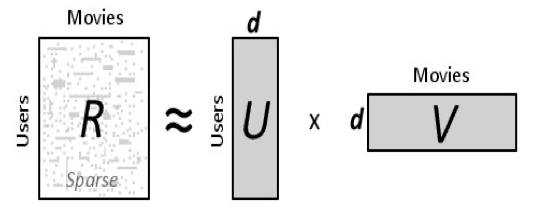
###**Choose hyperparameters**

In [ ]:
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8680061574535751
{'n_factors': 16}


In [ ]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset) ##call .fit_transform -->https://github.com/scikit-learn/scikit-learn/blob/844b4be24d20fc42cc13b957374c718956a0db39/benchmarks/bench_plot_nmf.py#L246
                       ##.fit_transform return Transformed data. ##--> call _fit_projected_gradient
                       ## return W, H, n_iter
                       ##https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF
                       

# Predict ratings for all pairs (u, i) that are NOT in the training set.
#testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [ ]:
type(predictions)

list

In [ ]:
predictions[:5]

[Prediction(uid=1, iid=21, r_ui=3.554996750961174, est=4.193618827815818, details={'was_impossible': False}),
 Prediction(uid=1, iid=32, r_ui=3.554996750961174, est=4.958632648585701, details={'was_impossible': False}),
 Prediction(uid=1, iid=45, r_ui=3.554996750961174, est=4.083512276825836, details={'was_impossible': False}),
 Prediction(uid=1, iid=52, r_ui=3.554996750961174, est=3.936468443240915, details={'was_impossible': False}),
 Prediction(uid=1, iid=58, r_ui=3.554996750961174, est=4.616189358009761, details={'was_impossible': False})]

In [ ]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
    '''
    #1. First map the predictions to each user.
    top_n = defaultdict(list) #defaultdict is created with the values that are list
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True) #reversed (or sorted in Descending order)
        top_n[uid] = user_ratings[: n ]
        
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
        
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

In [ ]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)


User 124 has already rated 50 movies.


In [ ]:
pred_NMF_124

,userId,movieId,rat_pred,title,genres
0,124,1136,5.000000,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
1,124,1283,5.000000,High Noon (1952),Drama|Western
2,124,3030,5.000000,Yojimbo (1961),Action|Adventure
3,124,1945,5.000000,On the Waterfront (1954),Crime|Drama
4,124,1172,5.000000,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
5,124,2360,5.000000,"Celebration, The (Festen) (1998)",Drama
6,124,2318,5.000000,Happiness (1998),Comedy|Drama
7,124,7099,4.988223,Nausicaä of the Valley of the Wind (Kaze no ta...,Adventure|Animation|Drama|Fantasy|Sci-Fi
8,124,3334,4.954967,Key Largo (1948),Crime|Drama|Film-Noir|Thriller
9,124,96821,4.947275,"Perks of Being a Wallflower, The (2012)",Drama|Romance
